<a href="https://colab.research.google.com/github/cahcharm/Neuro-and-Complexity-Science/blob/CSHA2021/project/project_spiking_circuit_model_for_working_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spiking circuit model for working memory**

Building up a spiking circuit model for working memory (Misha, Science, 2008). 

* Step 1: build LIF neuron, voltage jump synapse, STP synapse
*	Step 2: consider the connectivity used in the paper, build up the network model
*	Step 3: try to encode one item in the model (Fig. 2)
*	Step 4: try to encode two items in the network (Fig. 3)


In [1]:
pip install -U brainpy-simulator

In [2]:
import numpy as np
import brainpy as bp

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Step 1: build LIF neuron, voltage jump synapse, STP synapse

**Spiking network: LIF Neuron**

---

The network is composed of $N_E$ excitatory and $N_I$ inhibitory current-based integrate-and-fire neurons, whose sub-threshold depolarization dynamics is described by
$$
\tau_m \frac{dV_i}{dt} = - V_i + I_i^{(rec)}(t)+I_{i}^{(ext)}(t)
$$
where $i = 1,\cdots,(N_E+N_I)$ refere to the neuron number, $\tau_m$ is the membrane time constant, $I_i^{(rec)}(t)$ is the current mediated by recurrent synaptic connections, and $I_i^{(ext)}(t)$ is the external current provided by distant brain areas. Membrane resistance is absorbed into the definition of the currents.

When the depolarization hits a fixed threshold $\theta(V_i(t)\geq \theta)$， the neuron emits a spike and becomes refractory for a period $\tau_{arp}$ with a sub-threshold potential $V_r$

---

External current are modeld as Gaussian white noise
$$
I_i^{(ext)}(t) = \mu_{ext} + \sigma_{ext}\cdot \eta_i(t)
$$
with $\langle\eta_i(t)\rangle = 0, \langle \eta_i(t)\eta_j(t')\rangle = \delta_{ij}\delta(t-t')$, so that $\mu_{ext}$ and $\sigma_{ext}^2$ are respectively the mean and the variance of the external currents.

In [402]:
## Set external input
dt = 0.1 # [ms]
bp.backend.set(dt=dt)

# Single-cell parameters
theta_E = 20. # Spike emission threshold of excitatory cells [mV]
theta_I = 20. # Spike emission threshold of inhibitory cells [mV]
Vr_E = 16. # Reset potential of excitatory cells [mV]
Vr_I = 13. # Reset potential of inhibitory cells [mV]
tau_m_E = 15. # Membrane time constant of excitatory cells [ms]
tau_m_I = 10. # Membrane tiem constant of inhibitory cells [ms]
tau_arp_E = 2. # Absolute refractory period of excitatory cells [ms]
tau_arp_I = 2. # Absolute refractory period of inhibitory cells [ms]

## Network parameters
f = 0.10 # Coding level
p = 1 # Number of memories, 1 or 2 in this project
c = 0.20 # Probability of synaptic contact
N_E = 8000 # Number of excitatory cells
N_I = 2000 # Number of inhibitory cells
mu_ext_E = 23.10 # Mean external current of excitatory cells [mV]
mu_ext_I = 21.0 # Mean external current of inhibitory cells [mV]
sigma_ext_E = 1.0 # Standard deviation of external current of excitatory cells [mV]
sigma_ext_I = 1.0 # Standard deviation of external current of inhibitory cells [mV]

## Synaptic parameters
J_IE = 0.135 # Synaptic efficacy E to I [mV]
J_EI = 0.25 # Synaptic efficacy I to E [mV]
J_II = 0.20 # Synaptic efficacy I to I [mV]
J_b = 0.10 # Baseline level of E to E synapses [mV]
J_p = 0.45 # Potentiated level of E to E synapses [mV]
gamma_0 = 0.10 # Fraction of potentiated synapses before learning
delta_1, delta_2 = 0.1, 1  # Synaptic delays 0.1-1 ms

# Short-term synaptic dynamics parameters
U = 0.20 # Baseline utilization factor
tau_F = 1500 # Recovery time of utilization factor [ms]
tau_D = 200 # Recovery time of synaptic resources [ms]

Duration = 3000 # time from stimulus [ms]
# Selective stimulation
S_T_cue = 350 # Duration [ms]
S_A_cue = 1.15 # Contrast factor

# Reactivating signal
R_T_cue = 250 # duration [ms]
R_A_cue = 1.05 # Contrast factor

# Periodic reactivating signal
PR_T_cue = 100 # Duration [ms]
Period = 250 # Period [ms]
PR_A_cue = 1.075 # Contrast factor 

In [350]:
x = np.ones(3)
print(x)
y = np.array([1,2,3])
print(y)
print(y@x)
print(y*x)

[1. 1. 1.]
[1 2 3]
6.0
[1. 2. 3.]


In [425]:
class LIF(bp.NeuGroup):
  target_backend = ['numpy','numba']

  @staticmethod
  @bp.odeint
  def integral(V, t, Vr, Irec, Iext, tau_m):
    dvdt = (-V + Irec + Iext) / tau_m
    return dvdt

  def __init__(self, size, cls=1, theta=20., Vr=16., tau_m=15.,
          tau_arp=2., mu_ext=23.10, sigma_ext=1., **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)
    # size is the iteration number
    
    # # Single-cell parameters
    self.cls = cls 
    # judge the cell is excitatory or inhibitory, 0 for inhibitory, 1 for excitatory 

    if self.cls == 1:
      self.theta = theta_E
      self.Vr = Vr_E
      self.tau_m = tau_m_E
      self.tau_arp = tau_arp_E
      self.mu_ext = mu_ext_E
      self.sigma_ext = sigma_ext_E
    elif self.cls == 0:
      self.theta = theta_I
      self.Vr = Vr_I
      self.tau_m = tau_m_I
      self.tau_arp = tau_arp_I
      self.mu_ext = mu_ext_I
      self.sigma_ext = sigma_ext_I

    # variables
    self.t_last_spike = bp.ops.ones(self.num) * -1e7 # The last spike time for calculating refractory state
    self.refractory = bp.ops.zeros(self.num, dtype=bool) # Wether teh neuron is in refractory state
    self.Irec = bp.ops.zeros(self.num) # recurrent current from other synpase  
    self.spike = bp.ops.zeros(self.num, dtype=bool) # Whether produce a spike
    self.V = bp.ops.ones(self.num) * self.Vr # The membrane potential started from Vr
    self.input = bp.ops.zeros(self.num) # The external current provided by distant brain areas
    
  def update(self, _t):
    for i in range(self.num):
      spike = False
      refractory = (_t - self.t_last_spike[i]) <= self.tau_arp
      if not refractory:
        # calculate V
        V = self.integral(self.V[i], _t, self.Vr, self.Irec[i], self.input[i], self.tau_m)
        spike = (V >= self.theta)
        if spike:
          V = self.Vr
          self.t_last_spike[i] = _t # record last spike time
          refractory = True          
        self.V[i] = V
      self.spike[i] = spike
      self.refractory[i] = refractory
      self.Irec[i] = 0.
      self.input[i] = 0.

In [445]:
# set stimulation signal
idx_duration = int(200/dt)
input_A = bp.ops.ones(idx_duration)
idx_T_cue = int(30 / dt)
input_A[0: idx_T_cue] = 2
input_I = input_A*np.random.normal(mu_ext_E, sigma_ext_E, size=idx_duration)

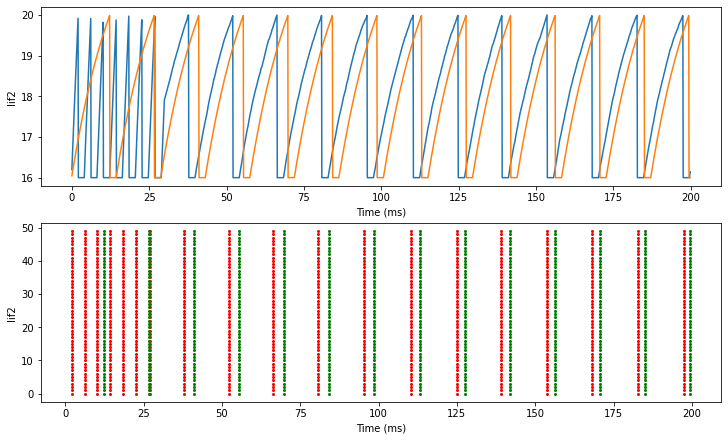

In [446]:
lif1 = LIF(size=50, cls=1, monitors=['V','spike']) # size is the iteration rounds
lif1.run(duration=200, inputs=('input', input_I)) # duration is the real time
lif2 = LIF(size=50, cls=1, monitors=['V','spike']) # size is the iteration rounds
lif2.run(duration=200, inputs=('input', mu_ext_E)) # duration is the real time

# plot
fig, gs = bp.visualize.get_figure(row_num=2, col_num=1, row_len=3, col_len=10)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(lif1.mon.ts, lif1.mon.V[:, 0], ylabel='lif1')
bp.visualize.line_plot(lif2.mon.ts, lif2.mon.V[:, 0], ylabel='lif2')
fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(lif1.mon.ts, lif1.mon.spike, markersize=4, color='r', ylabel='lif1')
bp.visualize.raster_plot(lif2.mon.ts, lif2.mon.spike, markersize=4, color='g', ylabel='lif2')

**Synapse**

The recurrent current $I_i^{(rec)}(t)$ is the sum of the postsynaptic currents from all other neurons in the network targeting the neuron i,
$$
I_i^{(rec)}(t) = \sum_j\hat{J}_{ij}(t)\sum_{k}\delta(t-t_k^{(j)}-D_{ij})
$$
where $\hat{J}_{ij}(t)$ is the instantaneous efficacy (time dependence is due to short-term synaptic dynamics) of the synapse connecting neuron $j$ to neuron $i$; the sum on $k$ is over all the emission times, $t_{k}^{(j)}$, of presynaptic neuron $j$; $D_{ij}$ is the transmission delay uniformly distributed between 1 and 5 ms. For simplicity, we neglect rise and decay times of the postsynaptic currents.

The $\hat{J}_{ij}(t)$ is given by
$$
\hat{J}_{ij}(t)=J_{ij}\cdot u_j(t-D_{ij})\cdot x_j(t-D_{ij})
$$
where $J_{ij}$ is the absolute synaptic efficacy. The remaining synaptic populations, inhibitory and excitatory-inhibitorym exhibit linear synaptic transmission, i.e., $\hat{J}_{ij}(t)=J_{ij}$. These equations are integrated using an Euler scheme.

---

Excitatory-to-excitatory synapses display short-term plasticity is

$$
\frac{du_j(t)}{dt} = \frac{U - u_j(t)}{\tau_F} + U[1-u_j^{-}(t)]\sum_k\delta(t-t_k^{(j)})\\
\frac{dx_j(t)}{dt}=\frac{1-x_j(t)}{\tau_D} - u_j^{+}(t)x_j^{-}(t)\sum_{k}\delta(t-t_k^{(j)})\\
u_j^{+}(t)=u_j^{-}(t)+U\left(1-u^{-}(t)\right)
$$

Or we can see the dynamics as:

$$
\frac {du} {dt} = \frac {U-u} {\tau_F}\\
\frac {dx} {dt} = \frac {1-x} {\tau_D}\\
$$

$$
\rm{if (pre \ fire), then}
\begin{cases} 
u^+ = u^- + U(1-u^-) \\ 
x^+ = x^- - u^+x^- 
\end{cases}
$$

where the functions multiplying the spike train are evaluated inmmediately before the delta functions,i.e. at $t_k^{(j)-}$. 


In [451]:
class STP(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  @staticmethod
  @bp.odeint(method='exponential_euler')
  def integral(u, x, t, U, tau_F, tau_D):
    dudt = (U - u) / tau_F 
    dxdt = (1 - x) / tau_D
    return dudt, dxdt
  
  def __init__(self, pre, post, conn, weight=1., tau_F=1500., tau_D=200., U=0.20, p=1., **kwargs):

    super(STP, self).__init__(pre=pre, post=post, **kwargs)

    # Short-term synaptic dynamics parameters
    self.U = U # Baseline utilization factor
    self.tau_F = tau_F # Recovery time of utilization factor [ms]
    self.tau_D = tau_D # Recovery time of synaptic resources [ms]
    self.w = weight
    self.p = p # non-selective to selective/non-selective have potentiated efficacy with probability 0.1

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = self.conn.requires('pre_ids','post_ids')
    self.num = len(self.pre_ids)

    # variables
    self.s = bp.ops.zeros(self.num)
    self.u = bp.ops.ones(self.num) * self.U
    self.x = bp.ops.ones(self.num)
    # self.delay = bp.ops.zeros(pre.num)
    self.delay = np.random.uniform(delta_1, delta_2, size=self.num)*dt
    self.I_syn = self.register_constant_delay('I_syn', size=self.num, delay_time=self.delay)
    # the transmission delay uniformly distributed between 0.1 and 1 ms.

  def update(self, _t):
    for i in range(self.num):
      pre_id, post_id = self.pre_ids[i], self.post_ids[i]
      u, x = self.integral(self.u[i], self.x[i], _t, self.U, self.tau_F, self.tau_D)
      # update
      self.s[i] = self.pre.spike[pre_id]
      if (self.w == J_b or self.w == J_p) and (np.random.rand() <= p) :
        I = self.w*self.u[i]*(_t-self.delay[i])*self.x[i]*(_t-self.delay[i])
      else:
        I = self.w
      self.I_syn.push(i, self.s[i] * I)
      u += self.s[i] * self.U * (1-self.u[i])
      x -= self.s[i] * u * self.x[i]

      # output
      self.u[i] = u
      self.x[i] = x 
      self.post.Irec[post_id] += self.I_syn.pull(i)

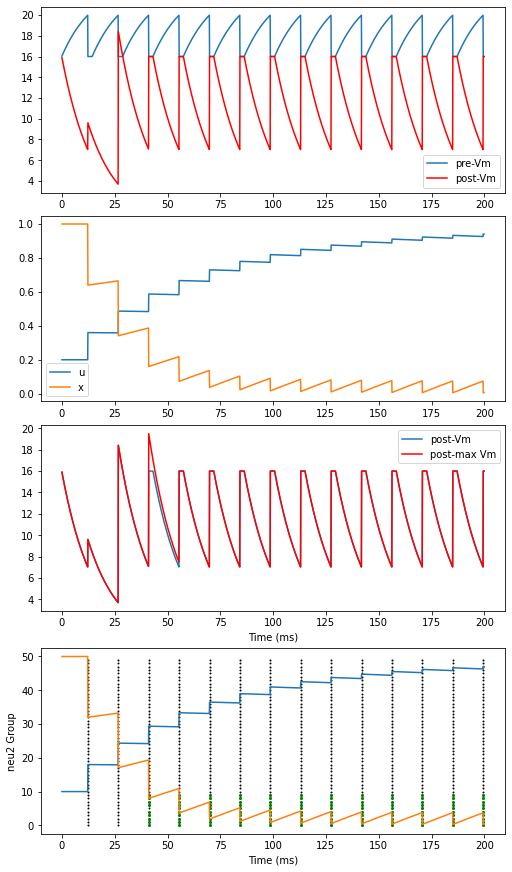

In [452]:
## STP
neu1 = LIF(50, monitors=['V','input','Irec','spike'])
neu2 = LIF(50, monitors=['V','input','Irec','spike'])

syn = STP(pre=neu1, post=neu2, conn=bp.connect.FixedPreNum(num=10),
      weight=J_p, monitors=['u', 'x'])
net = bp.Network(neu1, syn, neu2)
net.run(duration=200, inputs=(neu1, 'input', mu_ext_E))

# plot
fig, gs = bp.visualize.get_figure(row_num=4, col_num=1, row_len=3, col_len=7)

fig.add_subplot(gs[0, 0])
plt.plot(net.ts, neu1.mon.V[:, 0], label='pre-Vm')
plt.plot(net.ts, neu2.mon.V[:, 0], color='r', label='post-Vm')
plt.legend(loc='best')
fig.add_subplot(gs[1, 0])
plt.plot(net.ts, syn.mon.u[:, 0], label='u')
plt.plot(net.ts, syn.mon.x[:, 0], label='x')
plt.legend(loc='best')
fig.add_subplot(gs[2, 0])
plt.plot(net.ts, neu2.mon.V[:, 0], label='post-Vm')
plt.plot(net.ts, np.max(neu2.mon.V,axis=1), color='r', label='post-max Vm')
plt.legend(loc='best')
plt.xlabel('Time (ms)')
fig.add_subplot(gs[3, 0])
bp.visualize.raster_plot(net.ts, neu1.mon.spike, markersize=2, color='k', ylabel='neu1 Group')
bp.visualize.raster_plot(net.ts, neu2.mon.spike, markersize=4, color='g', ylabel='neu2 Group')
plt.plot(net.ts, np.mean(syn.mon.u, axis=1)*50, label='u')
plt.plot(net.ts, np.mean(syn.mon.x, axis=1)*50, label='x')

plt.show()

**Network connectivity**
There are $p$ items to be memorized, each of them encoded by a subset of excitatory cells (selective population). Every selective population is formed by randomly selected $fN_E$ neurons, where $f$ is the coding level, enforcing the constraint that a given neuron belongs to at most one selective population (non-overlapping memories). Network connectivity is generated in the following way. 

Each cell receives $c(N_E +N_I)$ presynaptic connections, where $c$ is the connectivity level, partitioned as follows: $cfN_E$ randomly selected connections from each of the selective populations, $c(1 − fp)N_E$ randomly selected connections from the non-selective excitatory population, and $cN_I$ randomly selected connections from the inhibitory population.

---

Excitatory-to-excitatory synapses can take on two possible absolute efficacies: baseline, $J_b$, and potentiated, $J_p(> J_b)$. Synapses connecting two neurons within the
same selective population have potentiated efficacy; Synapses connecting a selective neuron to a neuron from another selective population or to a non-selective neuron, have baseline efficacy; The remaining synapses (i.e. non-selective to selective and non-selective to non-selective) have potentiated efficacy with probability 0.1.

In [78]:
import warnings
warnings.filterwarnings('ignore')

In [334]:
# Network
def run_net(neu_model, syn_model, N_E=8000, N_I=2000, backend='numpy'):
  bp.backend.set(backend)

  N_E = N_E # Number of excitatory cells
  N_I = N_I # Number of inhibitory cells
  # define the ids of selective populations, non-selective excitatory population and inhibitory population
  num_S = int(f*N_E) # cell number of a selective population
  S_ids = range(p*num_S)
  nS_ids = range(p*num_S, N_E)
  I_ids = range(N_E, N_E+N_I)
  S = neu_model(num_S, cls=1, monitors=['spike'])
  nS = neu_model(N_E-p*num_S, cls=1, monitors=['spike'])
  I = neu_model(N_I, cls=0, monitors=['spike'])

  S2S = syn_model(pre=S, post=S, conn=bp.connect.FixedProb(prob=c*f), weight = J_p, monitors=['u','x'])
  S2nS = syn_model(pre=S, post=nS, conn=bp.connect.FixedProb(prob=c*f),weight = J_b, monitors=['u','x'])
  S2I = syn_model(pre=S, post=I, conn=bp.connect.FixedProb(prob=c*f), weight = J_EI, monitors=['u','x'])

  nS2S = syn_model(pre=nS, post=S, conn=bp.connect.FixedProb(prob=c*(1-f*p)), weight = J_p, p=0.1, monitors=['u','x'])
  nS2nS = syn_model(pre=nS, post=nS, conn=bp.connect.FixedProb(prob=c*(1-f*p)), weight = J_p, p=0.1, monitors=['u','x'])
  nS2I = syn_model(pre=nS, post=I, conn=bp.connect.FixedProb(prob=c*(1-f*p)), weight = J_EI, p=0.1, monitors=['u','x'])

  I2S = syn_model(pre=I, post=S, conn=bp.connect.FixedProb(prob=c), weight = J_IE, monitors=['u','x'])
  I2nS = syn_model(pre=I, post=nS, conn=bp.connect.FixedProb(prob=c), weight = J_IE, monitors=['u','x'])
  I2I = syn_model(pre=I, post=I, conn=bp.connect.FixedProb(prob=c), weight = J_II, monitors=['u','x'])
  
  net = bp.Network(S, nS, I,
            S2S, S2nS, S2I, nS2S, nS2nS, nS2I, I2S, I2nS, I2I)
  t = net.run(duration=T_cue, report=True)

  fig, gs = bp.visualize.get_figure(row_num=3, col_num=1, row_len=5, col_len=10)
  fig.add_subplot(gs[0, 0])
  bp.visualize.raster_plot(S.mon.ts, S.mon.spike, markersize=4, color='k', ylabel='E Group', xlabel='')
  fig.add_subplot(gs[1, 0])
  bp.visualize.raster_plot(nS.mon.ts, nS.mon.spike, markersize=4, color='g', ylabel='', show=True)
  fig.add_subplot(gs[2, 0])
  bp.visualize.raster_plot(I.mon.ts, I.mon.spike, ylabel='I Group', show=True)
  return t

In [335]:
WM = run_net(neu_model=LIF, syn_model=STP, N_E=200, N_I=50)

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



RunningError: ignored

In [ ]:
# Reactivating signal
R_Duration = 250 # Duration [ms]
R_cf = 1.05 # Contrast factor

In [ ]:
# Periodic reactivating signal
P_Duration = 100 # Duration
P_Period = 250 # Period
P_cf = 1.075 # Contrast factor

In [ ]:
def raster_plot(ts,
                sp_matrix,
                ax=None,
                marker='.',
                markersize=2,
                color='k',
                xlabel='Time (ms)',
                ylabel='Neuron index',
                xlim=None,
                ylim=None,
                title=None,
                show=False):
    """Show the rater plot of the spikes.

    Parameters
    ----------
    ts : np.ndarray
        The run times.
    sp_matrix : np.ndarray
        The spike matrix which records the spike information.
        It can be easily accessed by specifying the ``monitors``
        of NeuGroup by: ``neu = NeuGroup(..., monitors=['spike'])``
    ax : Axes
        The figure.
    markersize : int
        The size of the marker.
    color : str
        The color of the marker.
    xlim : list, tuple
        The xlim.
    ylim : list, tuple
        The ylim.
    xlabel : str
        The xlabel.
    ylabel : str
        The ylabel.
    show : bool
        Show the figure.
    """
    # get index and time
    elements = np.where(sp_matrix > 0.)
    index = elements[1]
    time = ts[elements[0]]

    # plot rater
    if ax is None:
        ax = plt
    ax.plot(time, index, marker + color, markersize=markersize)

    # xlable
    if xlabel:
        plt.xlabel(xlabel)

    # ylabel
    if ylabel:
        plt.ylabel(ylabel)

    if xlim:
        plt.xlim(xlim[0], xlim[1])

    if ylim:
        plt.ylim(ylim[0], ylim[1])

    if title:
        plt.title(title)

    if show:
        plt.show()

## Step 2: consider the connectivity used in the paper, build up the network model

In [19]:
dt = 0.0001  # [s]
bp.backend.set(dt=dt)

In [20]:
# the parameters of network
alpha = 1.5
J_EE = 8.  # the connection strength in each excitatory neural clusters
J_IE = 1.75  # Synaptic efficacy E → I
J_EI = 1.1  # Synaptic efficacy I → E
tau_f = 1.5  # time constant of STF  [s]
tau_d = .3  # time constant of STD  [s]
U = 0.3  # minimum STF value
tau = 0.008  # time constant of firing rate of the excitatory neurons [s]
tau_I = tau  # time constant of firing rate of the inhibitory neurons

Ib = 8.  # background input and external input
Iinh = 0.  # the background input of inhibtory neuron

cluster_num = 16  # the number of the clusters

In [21]:
# the parameters of external input

stimulus_num = 5
Iext_train = 225  # the strength of the external input
# the time interval between the consequent external input [s]
Ts_interval = 0.070
Ts_duration = 0.030  # the time duration of the external input [s]
duration = 2.500  # [s]

the working memory model based on STP was used to derive the expression for the postsynaptic current resulting from the activity of a large, uncorrelated pre-synaptic population.

The resulting network model has three differential equations for each of $P$ excitatory clusters (synaptic current $h_\mu$ and two STP variables $u_\mu$ and $x_\mu$ for each cluster $\mu; \mu = 1,..., P$) and one additional equation for the inhibitory pool current $h_I$:

$$
\begin{gathered}
\tau \frac{d h_{\mu}}{d t}=-h_{\mu}+J_{E E} u_{\mu} x_{\mu} R_{\mu}-J_{E l} R_{l}+I_{b}+I_{e}(t) \\
\frac{d u_{\mu}}{d t}=\frac{U-u_{\mu}}{\tau_{f}}+U\left(1-u_{\mu}\right) R_{\mu} \\
\frac{d x_{\mu}}{d t}=\frac{1-x_{\mu}}{\tau_{d}}-u_{\mu} x_{\mu} R_{\mu}, \text { and } \\
\tau \frac{d h_{I}}{d t}=-h_{I}+J_{I E} \sum_{\nu} R_{\nu}
\end{gathered}
$$

where $t$ is the neuronal time constant, for simplicity the same for excitation and inhibition; $I_b$ is the constant background excitation; and $I_e$ is the external input used to load memory items into the network. 

$$
R(h)=\alpha \ln (1+\exp (h / \alpha))
$$

is neuronal gain chosen in the form of a smoothed threshold-linear function, also the same for excitatory and inhibitory neurons. 

In [22]:
# the excitatory cluster model and the inhibitory pool model

class WorkingMemoryModel(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  def __init__(self, size, **kwargs):
    self.inh_h = 0.
    self.inh_r = self.log(self.inh_h)
    self.u = bp.ops.ones(cluster_num) * U
    self.x = bp.ops.ones(cluster_num)
    self.h = bp.ops.zeros(cluster_num)
    self.r = self.log(self.h)
    self.input = bp.ops.zeros(cluster_num)

    super(WorkingMemoryModel, self).__init__(size, **kwargs)

  @staticmethod
  @bp.odeint
  def int_exc(u, x, h, t, r, r_inh, Iext):
    du = (U - u) / tau_f + U * (1 - u) * r
    dx = (1 - x) / tau_d - u * x * r
    dh = (-h + J_EE * u * x * r - J_EI * r_inh + Iext + Ib) / tau
    return du, dx, dh

  @staticmethod
  @bp.odeint
  def int_inh(h, t, r_exc):
    h_I = (-h + J_IE * np.sum(r_exc) + Iinh) / tau_I
    return h_I

  @staticmethod
  def log(h):
    return alpha * np.log(1. + np.exp(h / alpha))

  def update(self, _t):
    self.u, self.x, self.h = self.int_exc(
        self.u, self.x, self.h, _t, self.r, self.inh_r, self.input)
    self.r = self.log(self.h)
    self.inh_h = self.int_inh(self.inh_h, _t, self.r)
    self.inh_r = self.log(self.inh_h)
    self.input[:] = 0.

In [23]:
# the external input

I_inputs = np.zeros((int(duration / dt), cluster_num))
for i in range(stimulus_num):
    t_start = (Ts_interval + Ts_duration) * i + Ts_interval
    t_end = t_start + Ts_duration
    idx_start, idx_end = int(t_start / dt), int(t_end / dt)
    I_inputs[idx_start: idx_end, i] = Iext_train


# model.monwork running

model = WorkingMemoryModel(cluster_num, monitors=['u', 'x', 'r', 'h'])
model.run(duration, inputs=['input', I_inputs])

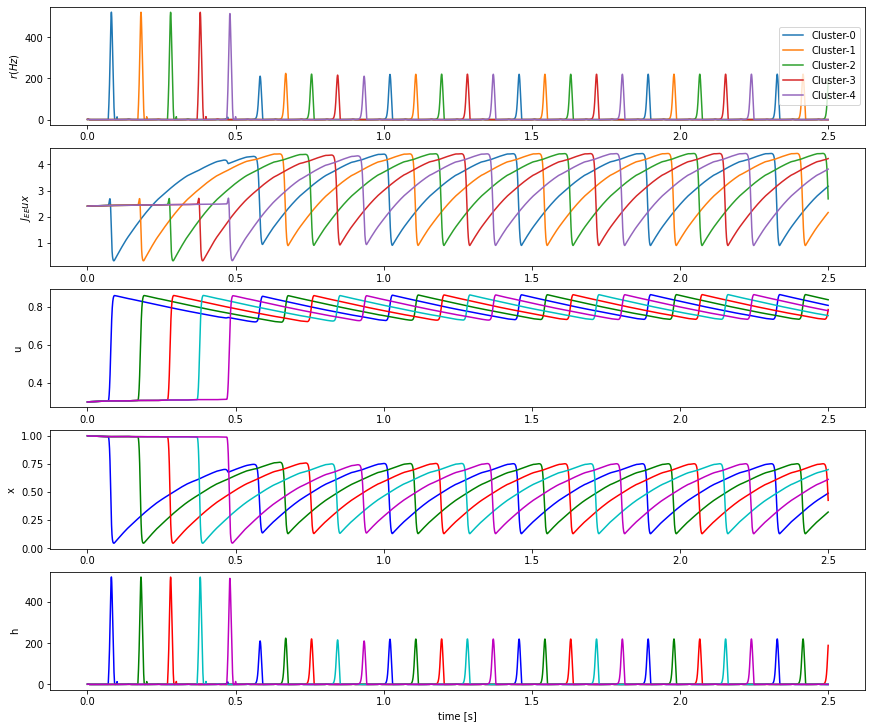

In [24]:
# visualization

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

fig, gs = bp.visualize.get_figure(5, 1, 2, 12)
fig.add_subplot(gs[0, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.r[:, i], label='Cluster-{}'.format(i))
plt.ylabel("$r (Hz)$")
plt.legend(loc='right')

fig.add_subplot(gs[1, 0])
hist_Jux = J_EE * model.mon.u * model.mon.x
for i in range(stimulus_num):
    plt.plot(model.mon.ts, hist_Jux[:, i])
plt.ylabel("$J_{EE}ux$")

fig.add_subplot(gs[2, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.u[:, i], colors[i])
plt.ylabel('u')

fig.add_subplot(gs[3, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.x[:, i], colors[i])
plt.ylabel('x')

fig.add_subplot(gs[4, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.r[:, i], colors[i])
plt.ylabel('h')
plt.xlabel('time [s]')

plt.show()

## Step 3: try to encode one item in the model (Fig. 2)

## Step 4: try to encode two items in the network (Fig. 3)

# Bifurcation Analysis

In [ ]:
class FHN(bp.NeuGroup):
  target_backend = 'numpy'

  def __init__(self, num, **kwargs):
    self.V = np.ones(num) * -2.8
    self.w = np.ones(num) * -1.8
    self.Iext = np.zeros(num)
    super(FHN, self).__init__(size=num, **kwargs)

  @bp.odeint
  def int_fhn(V, w, t, Iext):
    dw = (V + a - b * w) / tau
    dV = V - V * V * V / 3 - w + Iext
    return dV, dw

  def update(self, _t):
    self.V, self.w = int_fhn(self.V, self.w, _t, self.Iext)

    
group = FHN(1, monitors=['V', 'w'])
group.run(100., inputs=('Iext', 0.8, '='))
bp.visualize.line_plot(group.mon.ts, group.mon.V, legend='v', )
bp.visualize.line_plot(group.mon.ts, group.mon.w, legend='w', show=True)

In [ ]:
analyzer = bp.analysis.Bifurcation(
integrals=int_fhn,
target_pars={'Iext': [0., 1.]},
target_vars={'V': [-3, 3], 'w': [-3., 3.]},
numerical_resolution=0.001,
)
res = analyzer.plot_bifurcation(show=True)

In [ ]:
a = 1.; b = 3.; c = 1.; d = 5.; s = 4.
x_r = -1.6; r = 0.001; Vth = 1.9
@bp.odeint(method='rk4', dt=0.02)
def int_hr(x, y, z, t, Isyn):
  dx = y - a * x ** 3 + b * x * x - z + Isyn
  dy = c - d * x * x - y
  dz = r * (s * (x - x_r) - z)
  return dx, dy, dz

analyzer = bp.analysis.FastSlowBifurcation(
  integrals=int_hr,
  fast_vars={'x': [-3, 3], 'y': [-10., 5.]},
  slow_vars={'z': [-5., 5.]},
  pars_update={'Isyn': 0.5},
  numerical_resolution=0.001
)
analyzer.plot_bifurcation()
analyzer.plot_trajectory([{'x': 1., 'y': 0., 'z': -0.0}],
              duration=100., show=True)